In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import statistics
import xgboost as xgb

from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

In [20]:
type_target = 'hospitalisations'
assert type_target in ['hospitalisations', 'arrivees_urgences']
horizon = 15
NUM_FEATS = 50
DEPARTEMENT = 'Dijon'

In [21]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18,8)

def teste(df, params, score=100000, ma=7, verbose=False):
    MAEs, MSEs = [], []
    new_score = 100000
    reg_best = None
    final = df.loc[df.index.year==2023]
    X_final = final.drop('target', axis=1)
    y_final = final['target']

    for max_depth in [5]:
        params['max_depth'] = max_depth
        train_val_test = df.copy()
        for annee in range(2019, 2024):
            train_val = train_val_test.loc[train_val_test.index.year != annee]
            test = train_val_test.loc[train_val_test.index.year == annee]
            X_test = test.drop('target', axis=1)
            y_test = test['target']
            X_train, X_valid, y_train, y_valid = train_test_split(train_val.drop('target', axis=1), train_val['target'], 
                                                                  test_size=0.2, shuffle=False)
                    
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dvalid = xgb.DMatrix(X_valid, label=y_valid)
            dtest = xgb.DMatrix(X_test, label=y_test)
            evals = [(dtrain, 'train'), (dvalid, 'eval')]
            bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                            early_stopping_rounds=15, verbose_eval=verbose)
        
            y_pred = bst.predict(dtest)
            MAEs.append(mean_absolute_error(y_test, y_pred))
            MSEs.append(mean_squared_error(y_test, y_pred))

        current_score = statistics.mean(MSEs)
        if current_score < new_score:
            train_val_test = df.loc[df.index.year<2023]
            previous_score = new_score
            new_score = current_score
            if new_score < score:
                print(f"Amélioration avec {max_depth=}: {min(previous_score, score):.4f} -> {new_score:.4f}")
                new_score = statistics.mean(MSEs)
                X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                                    train_val_test['target'], 
                                                                    test_size=0.2, shuffle=False)

                dtrain = xgb.DMatrix(X_train, label=y_train)
                dvalid = xgb.DMatrix(X_valid, label=y_valid)
                dtest = xgb.DMatrix(X_final, label=y_final)
                evals = [(dtrain, 'train'), (dvalid, 'eval')]
                bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                                early_stopping_rounds=15, verbose_eval=verbose)
                reg_best = bst
                y_pred = bst.predict(dtest)
                #y_pred_ma = pd.Series(y_pred).rolling(window=ma, center=True).mean()
                N = 365
                plt.figure()
                plt.plot(range(len(y_final))[-N:], y_final[-N:], label='actual', color='blue')
                plt.plot(range(len(y_pred))[-N:], y_pred[-N:], label='predict', color='orange')
                #plt.plot(range(len(y_pred))[-N:], y_pred_ma[-N:], label='trend', color='red')
                plt.legend()
                '''y_test_ma = y_final.rolling(window=ma, center=True).mean()
                
                plt.figure()
                plt.plot(range(len(y_final)), y_test_ma, label='actual')
                plt.plot(range(len(y_pred)), y_pred_ma, label='predict')
                plt.legend()
                '''
                display(plt.gcf())

                mean_y_test = np.mean(y_final)
                error_percentage = np.abs((y_pred - y_final) / mean_y_test) * 100
                percent_below_thresholds = {}
                for threshold in range(1, 12):  # de 1% à 30%
                    percent_below = np.mean(error_percentage < threshold) * 100
                    percent_below_thresholds[threshold] = percent_below
                for threshold, percent_below in percent_below_thresholds.items():
                    print(f"{percent_below:.2f}%,{threshold}%")

                print(f"   - MAE : {statistics.mean(MAEs):.2f} ({mean_absolute_error(y_pred, y_final):.2f} sur 2023)")
                print(f"   - MSE : {statistics.mean(MSEs):.2f} ({mean_squared_error(y_pred, y_final):.2f} sur 2023)")
    return new_score, reg_best

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/julienaudoux/Desktop/WORK(lab)/forecasting_models/.venv/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['ma', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [22]:
assert type_target in ['hospitalisations', 'arrivees_urgences']
if type_target == 'hospitalisations':
    df = pd.read_excel('RPU_vers_hospit_adultes.xlsx')
    df['date_entree'] = pd.to_datetime(df['date_entree'], format="%d/%m/%Y")
    df.rename({'Total': type_target}, axis=1, inplace=True)
    df['target'] = df[type_target].copy()
    # on ajoute les arrivées aux urgences, que l'on suppose connues pour le jour J
    dff = pd.read_feather('CHU Dijon_volumes.feather')
    dff.rename({'Total': 'arrivees_urgences'}, axis=1, inplace=True)
    dff.reset_index(inplace=True)
    df = pd.merge(df, dff, on='date_entree')
else:
    df = pd.read_feather('CHU Dijon_volumes.feather')
    df.rename({'Total': type_target}, axis=1, inplace=True)
    df['target'] = df[type_target].copy()

In [23]:
# On ajoute la target
if type_target == 'hospitalisations':
    horizon = 7
else:
    horizon = 3
df['mean'] = df[type_target].rolling(window=horizon, min_periods=1).mean()
df['target'] = df['mean'].shift(-2*horizon+1)
df.drop('mean', axis=1, inplace=True)

df.dropna(inplace=True)
df.shape

(1813, 6)

<Axes: >

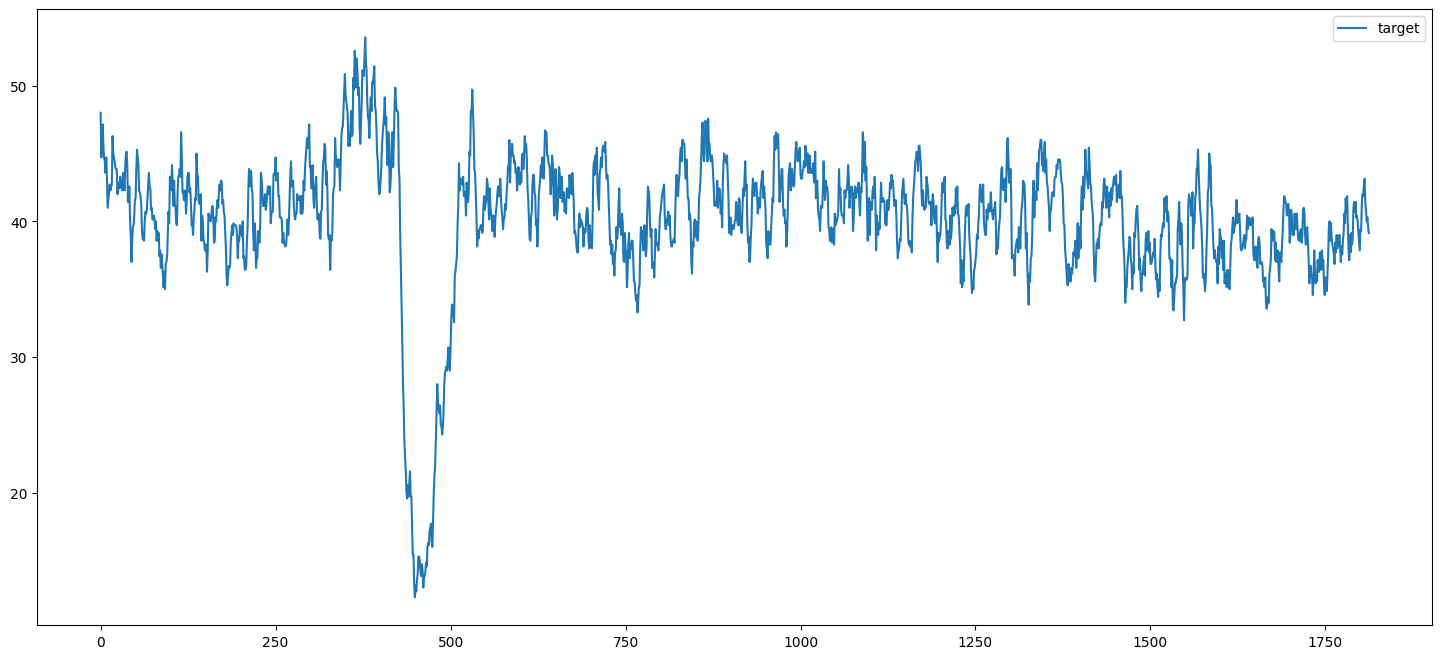

In [24]:
df.plot(y='target')

In [25]:
# df['Année'] = df.index.year

# plt.figure(figsize=(12, 6))
# for year, group in df.groupby('Année'):
#     plt.plot(group.index.dayofyear, group['target'], label=str(year))

# plt.xlabel("Jour de l'année")
# plt.ylabel("Target")
# plt.title("Target par année")
# plt.legend(title="Année", loc='upper right', fontsize='small')
# plt.grid(True)
# plt.show()


In [26]:
for k in range(2*horizon-1, 15):
    df[f'target_history-{k}'] = df['target'].shift(k)

In [27]:
for k in range(1, 15):
    df[f'{type_target}_history-{k}'] = df[type_target].shift(k)

In [28]:
dg = pd.read_csv('features_all_origin.csv', sep=',')
dg.drop('Total', axis=1, inplace=True)
dg['date_entree'] = pd.to_datetime(dg['date_entree'], format="%Y-%m-%d")
df = pd.merge(df, dg, on='date_entree', how='left')
df.set_index('date_entree', inplace=True)
df.dropna(inplace=True)

In [29]:
print(f"Moyenne : {df['target'].mean():.2f}, Ecart-type : {df['target'].std():.2f}")
print(f"Baseline : {mean_absolute_error(df['target'], [df['target'].mean()]*len(df)):.2f}")

Moyenne : 40.12, Ecart-type : 5.13
Baseline : 3.21


In [30]:
df['HNFC_moving'] = df['HNFC_moving']=='Après'
df.drop('nom_etablissement_x', axis=1, inplace=True)
df.drop('nom_etablissement_y', axis=1, inplace=True)
df = df.drop(df.loc['2020-03':'2020-05'].index)

In [31]:
shifted = df["target"].shift(2*horizon-1)
for ma in [2, 3, 7, 15, 30]:    
    window = shifted.rolling(window=ma)
    df[f'target_ma_{ma}'] = window.mean()
    df.bfill(inplace=True)

shifted = df[type_target].shift(1)
for ma in [2, 3, 7, 15, 30]:    
    window = shifted.rolling(window=ma)
    df[f'{type_target}_ma_{ma}'] = window.mean()
    df.bfill(inplace=True)


In [32]:
# On sauvegarde notre dataframe
df0 = df.copy()

In [33]:

def rank_features(df):
    params = {'eta': 0.05, 
            'objective': 'reg:absoluteerror', 
            'eval_metric': ['rmse', 'mae'],
            'subsample': 0.7, 
            'colsample_bytree': 1,
            'nthread': -1}

    new_score, bst = teste(df, params)

    importance_gain = bst.get_score(importance_type='gain')
    importance_cover = bst.get_score(importance_type='cover')
    importance_weight = bst.get_score(importance_type='weight')
    df_gain = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['gain'])
    df_cover = pd.DataFrame.from_dict(importance_cover, orient='index', columns=['cover'])
    df_weight = pd.DataFrame.from_dict(importance_weight, orient='index', columns=['weight'])
    df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
    df.fillna(0, inplace=True)
    df['gain_norm'] = df['gain'] / df['gain'].sum()
    df['cover_norm'] = df['cover'] / df['cover'].sum()
    df['weight_norm'] = df['weight'] / df['weight'].sum()
    w_gain = 0.5
    w_cover = 0.3
    w_weight = 0.2
    df['importance'] = (df['gain_norm'] * w_gain) + (df['cover_norm'] * w_cover) + (df['weight_norm'] * w_weight)
    df.sort_values(by='importance', ascending=False, inplace=True)
    df['rank'] = df['importance'].rank(ascending=False)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'feature'}, inplace=True)
    print(df[['feature', 'gain', 'cover', 'weight', 'importance', 'rank']].head(20))
    return df



In [34]:
best_features = False
if best_features:
    features = rank_features(df)
    cols = features['feature'].tolist()[:10]
else:
    cols = ['arrivees_urgences', 'air_PM10_FR26014_mean', 'trend_grippe_std', 'trend_maladie_mean', 'holidays', 
        'meteo_night_CHU DIJON_0_temp_mean', 'target_ma_7']
cols.append(type_target)

In [35]:
params = {'eta': 0.05, 
          'objective': 'reg:absoluteerror', 
          'eval_metric': ['rmse', 'mae'],
          'subsample': 0.7, 
          'colsample_bytree': 1,
          'nthread': -1}

horizon: 1
horizon: 2
horizon: 3
horizon: 4
horizon: 5
horizon: 6
horizon: 7
horizon: 8
horizon: 9
horizon: 10
horizon: 11
horizon: 12
horizon: 13
horizon: 14
horizon: 1
horizon: 2
horizon: 3
horizon: 4
horizon: 5
horizon: 6
horizon: 7
horizon: 8
horizon: 9
horizon: 10
horizon: 11
horizon: 12
horizon: 13
horizon: 14


<Axes: xlabel='date_entree'>

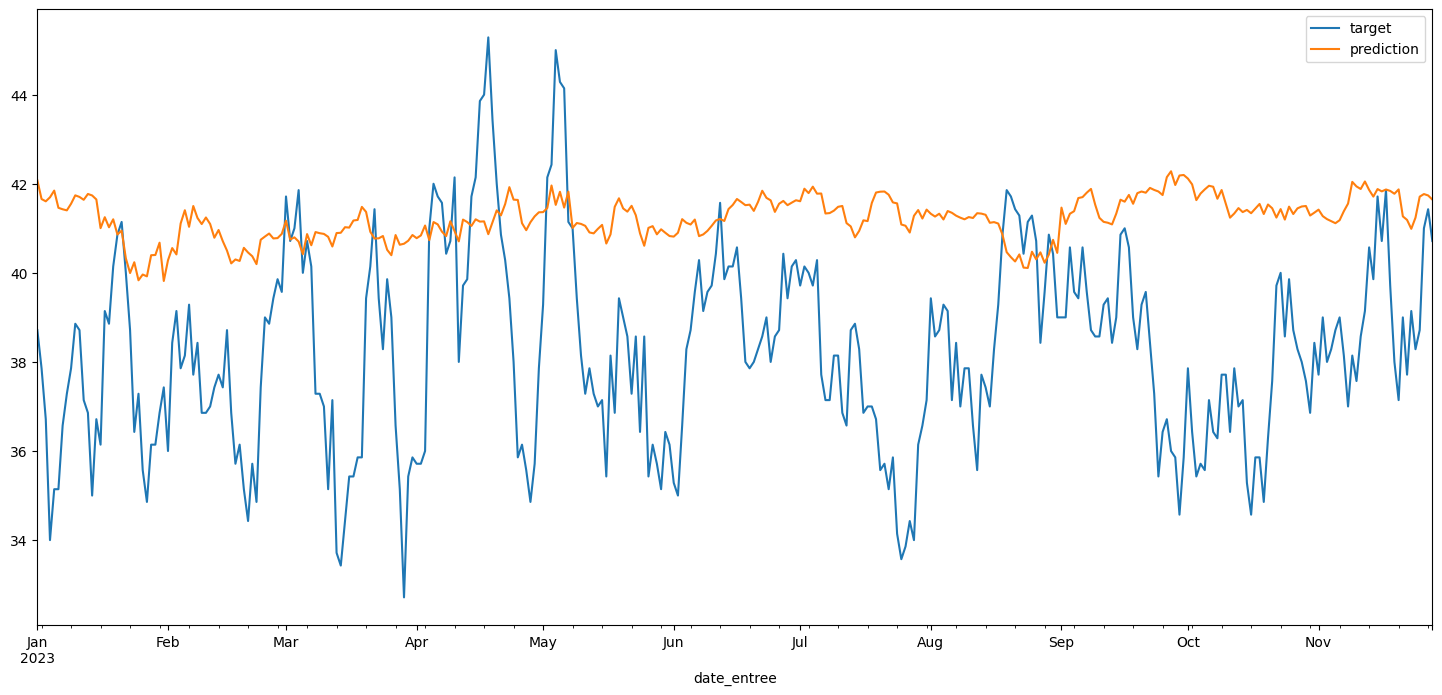

In [ ]:
regs = {'trend': {}, 'resid': {}, 'seasonal': {}}

for k in range(1, 2*horizon+1):
    print(f"horizon: {k}")
    dg = df[cols].copy()
    dg['target'] = dg[type_target].shift(-k)
    dg.dropna(inplace=True)
    regs['seasonal'][k] = seasonal_decompose(dg['target'], model='additive', period=7).seasonal
    dg['target'] = seasonal_decompose(dg['target'], model='additive', period=7).trend
    dg.dropna(inplace=True)
    train_val_test = dg.loc[dg.index.year < 2023]
    d_final = dg.loc[dg.index.year == 2023]
    X_final = d_final.drop('target', axis=1)
    y_final = d_final['target']
    X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                        train_val_test['target'], 
                                                        test_size=0.2, shuffle=False)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(dtrain, 'train'), (dvalid, 'eval')]
    regs['trend'][k] = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                        early_stopping_rounds=15, verbose_eval=False)
    y_pred = regs['trend'][k].predict(xgb.DMatrix(X_final))
    dg[f'target'] = seasonal_decompose(dg['target'], model='additive', period=7).resid
    dg.dropna(inplace=True)
    train_val_test = dg.loc[dg.index.year < 2023]
    d_final = dg.loc[dg.index.year == 2023]
    X_final = d_final.drop('target', axis=1)
    y_final = d_final['target']
    X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                        train_val_test['target'], 
                                                        test_size=0.2, shuffle=False)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(dtrain, 'train'), (dvalid, 'eval')]
    regs['resid'][k] = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                        early_stopping_rounds=15, verbose_eval=False)
    y_pred = regs['resid'][k].predict(xgb.DMatrix(X_final))
    df[f'{type_target}+{k}'] = dg.target.copy()

dg = df.copy()
for k in range(1, 2*horizon+1):
    print(f"horizon: {k}")
    X_final[f'{type_target}+{k}'] = regs['trend'][k].predict(xgb.DMatrix(X_final[regs['trend'][k].feature_names]))
    X_final[f'{type_target}+{k}'] += regs['resid'][k].predict(xgb.DMatrix(X_final[regs['resid'][k].feature_names]))
    X_final[f'{type_target}+{k}'] += regs['seasonal'][k]


X_final['prediction'] = X_final.apply(lambda x: statistics.mean([x[f'{type_target}+{k}'] for k in range(horizon, 2*horizon)]), axis=1)

X_final['target'] = df.loc[df.index.year == 2023]['target']
X_final.plot(y=['target', 'prediction'], title=f'{type_target}, MAE: {mean_absolute_error(X_final["target"], X_final["prediction"]):.2f}')


In [37]:
mean_absolute_error(X_final['target'], X_final['prediction'])

3.2129475990645866